In [50]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
import os
import time
import unicodedata
import matplotlib.pyplot as plt

In [5]:
main_url="https://townhall.virginia.gov/L/Comments.cfm?GdocForumID=1953"

orig_url="https://townhall.virginia.gov/L/GDocForum.cfm?GDocForumID=452"

In [6]:
html_content = requests.get(main_url).text
soup = BeautifulSoup(html_content, "lxml")
main_tab = soup.find('table')

In [73]:
# save off raw html
with open("raw_html.txt", "w") as text_file:
    text_file.write(html_content)

In [ ]:
with open('raw_html.txt', 'r') as file:
    html_content = file.read()

In [28]:
df = pd.read_html(str(main_tab))[0]

In [57]:
urls = [re.search('.+=([0-9]+)', r.a['href']).group(1) for r in main_tab.find_all('tr')]
df['commentId'] = urls[1:]

In [66]:
df.head(3)

,Comment Title,Commenter,Date,commentId,full_comment
0,I am strongly opposed.,Latosha Misciagna,9/26/22 4:27 pm,136285,
1,Awful legislation!,Vincent J. Albiani,9/26/22 4:27 pm,136284,
2,This is a terrible policy decision.,Gaye Degrazio,9/26/22 4:27 pm,136283,


In [41]:
df.tail(3)

,Comment Title,Commenter,Date
7313,Transgender pronkun,Anonymous (128950),9/26/22 5:24 am
7314,Wholly support the 2022 guidance,"LH, Fairfax County Public Schools mother",9/26/22 2:37 am
7315,Protect Kids,Cassidy Moulton-Hill,9/26/22 12:30 am


In [72]:
# loop over all entries, update in place
df['full_comment'] = ''
for i in range(df.shape[0]):
    url=f"https://townhall.virginia.gov/L/viewcomments.cfm?commentid={df.loc[i,'commentId']}"
    soup2 = BeautifulSoup(requests.get(url).text, "lxml")
    df.loc[i,'full_comment'] = soup2.find(attrs={"class": "divComment"}).text

In [75]:
df.to_csv('1953_comments.csv')

## Alt method - full comments page, paginated

In [93]:
base_url = "https://townhall.virginia.gov/L/ViewComments.cfm?GdocForumID=1953"
params = {"vPage": 1,
  "vPerPage": 999,
  "sub1": "go"}

In [94]:
pagecount = 99
params['vPage'] = 1

dfc = pd.DataFrame()

while params['vPage'] <= pagecount:
    r = requests.post(base_url, data=params)
    soup = BeautifulSoup(r.text, "lxml")
    try:
        pagecount = int(soup.find(id="page").div.a.text)
    except:
        pagecount = 0
    print(f"page {params['vPage']}/{pagecount}")
    params['vPage'] += 1
    boxes = soup.find_all(attrs={"class": "Cbox"})
    for box in boxes:
        comment = {"Date": unicodedata.normalize("NFKD", box.contents[1].div.get_text(strip=True)),
           "Commenter": box.contents[3].contents[2].strip(),
           "Comment Title": box.contents[3].find_all('strong')[1].get_text(strip=True),
           "Comment": box.find(attrs={"class":"divComment"}).get_text(strip=True),
           "CommentID": int(box.find(attrs={"class":"linklight"}).get_text(strip=True))}
        dfc = dfc.append(comment, ignore_index=True)


page 1/23
page 2/23
page 3/23
page 4/23
page 5/23
page 6/23
page 7/23
page 8/23
page 9/23
page 10/23
page 11/23
page 12/23
page 13/23
page 14/23
page 15/23
page 16/23
page 17/23
page 18/23
page 19/23
page 20/23
page 21/23
page 22/23
page 23/23


In [95]:
print(dfc.shape)
print(len(dfc['CommentID'].unique()))

(22233, 5)
22233


In [96]:
dfc.to_csv('all_comments.csv')

In [ ]:
# read back from csv

In [ ]:
# feature eng

In [97]:
dfc['alltext'] = (dfc['Comment Title'] + ' ' + dfc['Comment']).str.lower()

In [98]:
dfc['support'] = dfc['Comment Title'].str.lower().str.contains('support')
dfc['oppose'] = dfc['Comment Title'].str.lower().str.contains('oppose')

In [102]:

print(f"Total: {dfc.shape[0]} comments")
print("Using title alone...")
print(f"Support policy: {dfc['support'].sum()} comments, avg length {dfc.loc[dfc['support']]['Comment'].str.len().mean():.0f}")
print(f"Oppose policy: {dfc['oppose'].sum()} comments, avg length {dfc.loc[dfc['oppose']]['Comment'].str.len().mean():.0f}")
print(f"Unclear: {(~dfc['support'] & ~dfc['oppose']).sum()} comments, avg length {dfc.loc[(~dfc['support'] & ~dfc['oppose'])]['Comment'].str.len().mean():.0f}")
print(f"Intersect: {(dfc['support'] & dfc['oppose']).sum()}")

Total: 22233 comments
Using title alone...
Support policy: 3229 comments, avg length 259
Oppose policy: 10268 comments, avg length 239
Unclear: 8840 comments, avg length 279
Intersect: 104


In [103]:
dfc.iloc[19975].alltext

"strongly oppose strongly oppose youngkin's hateful policy change!\xa0 all students deserve the right to feel safe and respected in school."

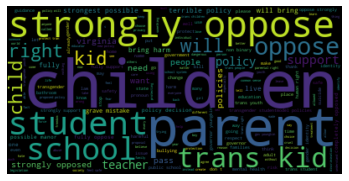

In [104]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, get_single_color_func
# Create stopword list:
stopwords = set(STOPWORDS)
textt = " ".join(t for t in dfc.alltext)
wordcloud = WordCloud().generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud11.png')
plt.show()

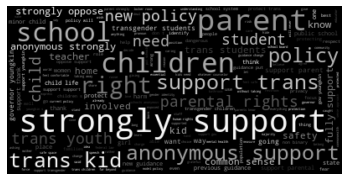

In [105]:
pos2 = " ".join(c for c in pos.alltext)
cf = get_single_color_func('#fff')
pwc = WordCloud(stopwords=stopwords, color_func=cf).generate(pos2)
plt.imshow(pwc, interpolation='bilinear')
plt.axis("off")
plt.show()

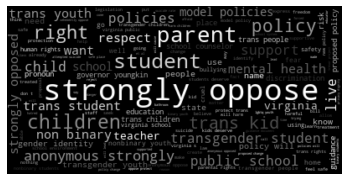

In [107]:
neg2 = " ".join(c for c in neg.alltext)
cf = get_single_color_func('#fff')
nwc = WordCloud(stopwords=stopwords, color_func=cf).generate(neg2)
plt.imshow(nwc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [108]:
# process text field
cleantext = []

for sentence in dfc['alltext']:
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(sentence))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    cleantext.append(processed_feature)
    
dfc['cleantext'] = cleantext

In [109]:
# segment training data from unknown data

dfc['label'] = 'Unknown'
dfc.loc[dfc['support'],'label'] = 'Support'
dfc.loc[dfc['oppose'],'label'] = 'Oppose'
dfc.loc[(dfc['support'] & dfc['oppose']), 'label'] = 'Unknown'

train = dfc.loc[dfc['label'] != 'Unknown',:]
unk = dfc.loc[dfc['label'] == 'Unknown']

In [122]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(train['cleantext']).toarray()


In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_features, train['label'], test_size=0.2, random_state=0)

In [124]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [125]:
predictions = text_classifier.predict(X_test)

In [126]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[2038    1]
 [  20  599]]
              precision    recall  f1-score   support

      Oppose       0.99      1.00      0.99      2039
     Support       1.00      0.97      0.98       619

    accuracy                           0.99      2658
   macro avg       0.99      0.98      0.99      2658
weighted avg       0.99      0.99      0.99      2658

0.9920993227990971


In [127]:
unk_input = vectorizer.transform(unk['cleantext']).toarray() # don't re-fit the vectorizer!
real_preds = text_classifier.predict(unk_input)
unk['pred'] = real_preds

<ipython-input-127-c844b9fc9b88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unk['pred'] = real_preds


In [130]:
unk.groupby(['pred']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext,label
pred,,,,,,,,,,
Oppose,7390,7390,7390,7390,7390,7390,7390,7390,7390,7390
Support,1554,1554,1554,1554,1554,1554,1554,1554,1554,1554


In [135]:
train.groupby(['label']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext
label,,,,,,,,,
Oppose,10164,10164,10164,10164,10164,10164,10164,10164,10164
Support,3125,3125,3125,3125,3125,3125,3125,3125,3125


In [142]:
train['pred'] = ''
output_df = train.loc[:,['CommentID','Commenter','Comment Title','Comment','label','pred']]
output_df = output_df.append(unk.loc[:,['CommentID','Commenter','Comment Title','Comment','label','pred']])

<ipython-input-142-13e510e12654>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred'] = ''


In [143]:
output_df.to_csv('output.csv',index=False)